In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


This is my first time working with Neural Networks. As a beginner, I learned a lot from other notebooks on Kaggle, especially Yassine Ghouzam's.

Let's start by importing the libraries we need. To build our neural network, we'll use keras.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Let's import the data. We already have a dataset for training and one for testing.

In [3]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv") #labelled
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv") #not labelled

In [4]:
#check for missing values
train_data.isna().any().any()

False

In [5]:
test_data.isnull().any().any()

False

In [6]:
train_y = train_data["label"]
train_x = train_data.drop(labels = "label", axis = 1)

We notice there are no missing values. So we can proceed.

Now we normalize the data. The model will work better if the values are between 0 and 1. From the description of the dataset, we know that: "Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive." Thus, if we divide our values by 255, proportions will hold but all values will be between 0 and 1.

In [7]:
train_x = train_x / 255
test_data = test_data / 255

The images are stored as 1D lists of 784 values. We notice that 784 = 28^2. Thus, we can reshape our data into 28 * 28 images.

In [8]:
#reshape data
train_x = train_x.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)

Encode labels (1,2,3 etc.) to one-hot vectors. For example, 1 becomes 0100000000

In [9]:
train_y = to_categorical(train_y, num_classes = 10)

In [10]:
random_seed = 2
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = random_seed)

Let's see how our digits look like, as 28 * 28 pixel images.

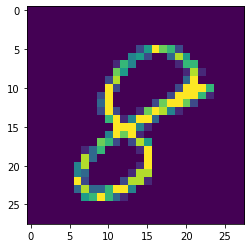

In [11]:
g = plt.imshow(train_x[0][:,:,0])

Let's build the model. I learned this from Yassine Ghouzam's notebook.

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2))) #reduce computational cost, picks maximum value between two neighbourhing pixels
model.add(Dropout(0.25)) #reduce overfitting by ignoring some nodes randomly


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Set up optimizer to improve parameters.

In [13]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
epochs = 1 #only one epoch to fit the model quickly
batch_size = 86 #86 digits passed each time through the model

In [15]:
history = model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, 
                    validation_data = (val_x, val_y), verbose = 2) 

#verbose is just a parameter to decide how the fitting is proceeding

440/440 - 130s - loss: 0.2493 - accuracy: 0.9222 - val_loss: 0.0925 - val_accuracy: 0.9719


Now we can see our results on the validation data. Since we have achieved a pretty good accuracy without training the model for too long, we can run the model on the test data and submit our results.

In [16]:
results = model.predict(test_data)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)